# Quantization: from simple division to dither and noise shaping

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as spla
import scipy.signal as signal
import IPython.display as ipd
import ipywidgets as ipw
import scipy.io.wavfile as wavfile

%matplotlib inline

#### Side note: STFT code

We'll be doing a lot of spectral analysis based on the spectra in short overlapping segments, so instead of using [`scipy.signal.spectrogram`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html) for that purpose, we choose to roll our own mainly for didactic reasons. So before we start with the main material of this notebook, we define a function for computing the STFT, including a function for the analysis window design.

In [2]:
def stft_window(fft_size=1024, block_size=1024, overlap=0.5,
                win_type='hanning', symmetric_zp=False):
    '''
    Computes the analysis STFT window.

    Parameters
    ----------
    fft_size : int, optional (default = 1024)
        Size of the STFT segment.
    block_size : int, optional (default = 1024)
        Size of the non-zero block inside the segment.
    overlap : float, optional (default = 0.5)
        Overlap between consecutive blocks.
    win_type : {'hanning', 'hamming', 'rect'}, optional (default = 'hanning')
        Type of the window used.
    symmetric_zp : bool, optional (default = False)
        If True, apply symmetric zero-padding; if False, zero-pad at the end.

    Returns
    -------
        win : 1D array_like
            (fft_size,) array with the window function.
    '''
    zp_length = fft_size - block_size
    if symmetric_zp:
        start = zp_length // 2
    else:
        start = 0
    indices = range(start, start+block_size)

    # Compute the analysis window.
    win = np.zeros(fft_size)
    gain = 2 * (1 - overlap)

    if win_type.lower() == 'hanning':
        win[indices] = np.hanning(block_size)
    elif win_type.lower() == 'hamming':
        win[indices] = np.hamming(block_size)
    elif win_type.lower() == 'rect':
        win[indices] = 1
    else:
        raise ValueError('Window type could be hanning, hamming or rect')
    return gain * win


def stft(x, win, hop_size, fullspec=False):
    '''
    Compute the STFT (spectrogram) of a signal.

    Parameters
    ----------
    x : array_like
        (L,) array with the signal.
    win : 1D array_like
        (W,) array with the window function used for STFT computation.
    hop_size : int
        Hop size between two consecutive segments.
    fullspec : bool, optional (default = False)
        Computing full spectrum or only positive frequencies.

    Returns
    -------
        seg_offsets : array_like
        (n_segments,) array the index of the first sample of every segment.
        freqs : array_like
        (spec_size,) array with bin frequencies normalized by f_s/2 (Nyquist).
        sxy : array_like
        (n_segments, spec_size) STFT of the cross-spectral density.
    '''

    # Compute the analysis window.
    fft_size = len(win)

    if fullspec:
        spec_size = fft_size
    else:
        # Use only with frequencies up to the Nyquist.
        spec_size = fft_size//2+1 if fft_size % 2 == 0 else (fft_size+1)//2
        
    freqs = np.arange(0, spec_size) / fft_size

    # Get the starts of the segments to be processed.
    seg_offsets = np.arange(0, x.shape[0]-fft_size, hop_size)
    n_segments = len(seg_offsets)

    S = np.zeros((spec_size, n_segments), dtype=np.complex128)
    n = 0
    for offset in seg_offsets:
        if fullspec:
            S[:, n] = np.fft.fft(win * x[offset:offset+fft_size])
        else:
            S[:, n] = np.fft.rfft(win * x[offset:offset+fft_size])
        n += 1
    return seg_offsets, freqs, S

## Introduction

In DSP, quantization is part of life. It happens at the interface between the analog and the digital world (usually following sampling), and is an operation by which an analog physical quantity at the input, which we could imagine to be of infinite precision, gets converted to a number represented by a finite number of (binary) digits.

Analog-to-digital conversion is not the only conversion where quantization happens. One is often forced to perform quantization in the digital domain where the intermediate representation is of higher resolution than the resolution used at the system output. This particular type of quantization between different digital representations is called *requantization*. For instance, in audio it is not uncommon to make high-resolution acquisition with A/D converters of more than 16 bits (up to 24), keep a $24$-bit representation for the sake of processing, but then having to produce audio streams in 16-bit PCM used by CD's.

Typically, the signal being quantized is confined to a certain range. Let's say the interval $[s_{\it min},s_{\it max}]$ is the smallest such interval, and it is divided up in $N$ subintervals. A quantizer maps the value of its input to the index (a value between $0$ and $N-1$) of the subinterval that contains the input value. Instead of the index, the quantizer is usually considered to output a concrete value, and that value is the center of the input value-enclosing interval.

For convenience, $N$ is oftentimes a power of 2 ($N=2^b$), and the minimum number of bits $b$ needed to represent $N$ is used to characterize the quantizer as being $b$-bit.

### Uniform quantizer

The most common quantizer type is what's known as the *uniform quantizer*, whose quantization subintervals are of equal size $\Delta$ (commonly called *quantization step size*) and the output values are equally spaced. The step size is also referred to as 1 LSB, as the change of one least significant bit in the quantization output index (a number between $0$ and $N-1$) corresponds to a change of output equal to $\Delta$.

There are two subtypes of uniform quantizers and they only differ in how they divide the quantized range into intervals. Those are
1. *Mid-tread quantizers* or *quantizers with a deadzone*, whose mapping is given by
$$ Q(x) = \left\lfloor \frac{x + 0.5}{\Delta} \right\rfloor $$
2. *Mid-rise quantizers*, whose input-output mapping takes the form
$$ Q(x) = \left\lfloor \frac{x}{\Delta} \right\rfloor + \frac{\Delta}{2} ,$$

where $\lfloor x \rfloor$ denotes the largest integer not larger than $x$.

<img src="figures/quantizer_input_output.png" width=500>

We should also mention here that there is a large class of non-uniform quantizers (very popular in speech coding), but they can usually be modeled by a non-linearity followed by uniform quantization. Since uniform quantizers seem to be relevant even for other types of quantizers, we will only be dealing with them.

#### Code example: input-output characteristics of uniform quantizers

In [3]:
def quantize(x, step, midrise=False):
    if midrise:
        y = np.floor(x / step) * step + step / 2
    else:
        y = np.floor(x / step + 0.5) * step
    return y

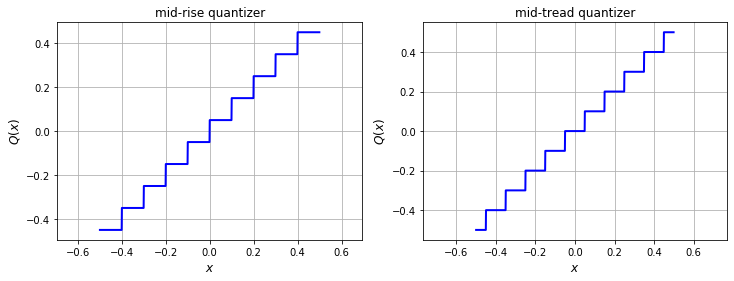

In [4]:
step = 0.1
x = np.arange(-5*step, 5*step, step/100)

y_mr = quantize(x, step, midrise=True)
y_mt = quantize(x, step, midrise=False)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(x, y_mr, color='b', linewidth=2)
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$Q(x)$', fontsize=12)
plt.axis('equal')
plt.title('mid-rise quantizer')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(x, y_mt, color='b', linewidth=2)
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$Q(x)$', fontsize=12)
plt.axis('equal')
plt.title('mid-tread quantizer')
plt.grid()

plt.show()

## Conventional quantization theory

Quantization is a lossy operation. Namely, as whole intervals get mapped onto a single value, there is no way to recover the exact value of the input by seeing the output (mathematicians would say that the quantization function is not injective, so it doesn't have an inverse).

*Quantization error* $e$ is the difference between the signal at the quantizer's input and its output, $e = y - x$. Since the output of quantization corresponds to the center of the interval containing the input value, conventional quantization theory models the error $e$ at any time instant as a *uniformly distributed random variable* in the interval $[-\Delta/2,\Delta/2)$. Furthermore, according to this model, quantization error $e$ viewed as a time-domain signal is a *white noise process* with zero mean and power $\Delta^2/12$ (which follows from the properties of the uniform distribution).

The signal-to-noise ratio (SNR) of a uniform quantizer is expressed in reference to a peak-to-peak sinusoidal signal as the input. If the quantizer has $N=2^b$ levels in the range $[s_{\it min},s_{\it max}]$ and the sinusoid has the amplitude $(s_{\it max}-s_{\it min})/2$, the SNR is given by

$$
\text{SNR} = 10 \log_{10} \frac{(s_{\it max}-s_{\it min})^2 / 8}{\Delta^2 / 12} = 
    10 \log_{10} \frac{(2^{b}\Delta)^2}{\Delta^2} + 10 \log_{10} \frac{3}{2} =
    10 b \log_{10} 4 + 10 \log_{10} \frac{3}{2}
$$

and expressed shortly

$$
\text{SNR} = 6.02 b + 1.76 ~\text{dB}.
$$

The above formula is oftentimes used as the basis for the claim that every bit added to the representation of a signal increases the SNR by 6 dB. Furthermore, one should now see the rationale behind the often-used claim that a 16-bit representation gives an SNR of 96 dB and that the dynamic range of 16-bit PCM audio (used by audio CD's) is 96 dB.

The model of the quantization error mentioned above is valid only for a family of input signals with very particular statistical properties; it is therefore not of universal relevance. The formula for SNR is also of limited accuracy, as the SNR tends to decrease as quantization gets coarser. When the quantizer is of high resolution however, this model is fairly accurate and illustrative.

### Quantization error as distortion

If we think again of the mapping performed by a quantizer, we can see that there is nothing stochastic about it. Namely, given any input signal, we can easily compute the quantizer's output and the quantization error, so it shouldn't come as a surprise that the error is unlikely to look like noise, especially if the input signal is simple and well structured, as is the case for sinusoidal signals.

This easily becomes apparent as one decreases the quantizer's resolution (or decreases the input signal's power while keeping the resolution constant). If we keep things simple and quantize a sinusoidal signal with a coarse uniform quantizer, we can easily notice a patterned shape of the quantization error. Furthermore, the spectrum of the quantized signal in this case contains not only one line at the sinusoid's frequency, but several spectral lines with amplitudes high above what appears to be the noise floor. Also, upon listening, one gets convinced that the quantization error in this particular case is best described as *distortion*, rather than noise, and appears much more detrimental to the signal than would be the noise of equal power.

#### Code example: listening to the quantization error

In this first example, we try to see how the quantized signal and quantization error look and sound like as we vary the quantizer's resolution, or more precisely - the ratio between the signal power and the quantization step size.

Things one should pay attention to are the spectrum of the quantized signal as compared to the spectrum of the original, and the spectrum of the quantization error. 

Moreover, one should also play the corresponding sounds and see how the quantized signal changes relative to the original as the resolution of the quantizer is decreased.

In [5]:
# The influence of the number of quantization steps on the quantization error.

# Sampling frequency in Hz.
fs = 44100
# Signal duration in seconds.
duration = 5

# Number of samples for which we plot the time-domain signals.
nt = 600
# Regularization constant to avoid taking a log of zero.
mu = 1e-6

# Define the widgets to control the demo parameters.
win_type_dd_1 = ipw.Dropdown(options=['rect', 'hanning', 'hamming'],
                           value='hanning', description='Window type',
                           disabled=False)

fft_size_dd_1 = ipw.Dropdown(options=[256, 512, 1024, 2048, 4096, 8192, 16384],
                           value=4096, description='FFT size',
                           disabled=False)

midrise_dd_1 = ipw.Dropdown(options=[('midrise', True), ('mid-tread', False)],
                          value=True, description='Quantizer type', 
                          disabled=False)

a_db_fs_1 = ipw.FloatSlider(
    min=-96, max=0, step=-3, value=-6, description='$a$ [dB]')
f_fs_1 = ipw.FloatSlider(
    min=100, max=5000, step=10, value=440, description='$f_0$')
nbits_is_1 = ipw.IntSlider(
    min=1, max=24, step=1, value=10, description='$n_{\it bits}$')

demo_out_1 = ipw.Output()

default_layout = ipw.Layout(
    border='solid 1px black',
    margin='0px 10px 10px 0px',
    padding='5px 5px 5px 5px')

def update_no_dither(a, f, nbits, midrise=False, 
                     win_type='rect', fft_size=4096):
    t = np.arange(0, duration, 1/fs)
    x = a * np.sin(2 * np.pi * f * t + 1)
    step_size = 2 / 2**nbits
    
    # Prepare the windowing function.
    win = stft_window(fft_size, fft_size, win_type=win_type)
    # Work with a 50% overlap.
    hop_size = fft_size // 2
    
    y = quantize(x, step_size, midrise)
    e = x - y
    
    # Create the idealized noise power reference.
    quant_noise = (np.random.random(len(t)) - 0.5) * step_size
    
    # Compute the spectra of y and e by averaging the STFT magnitude.
    _, f_n, Y_s = stft(y, win, hop_size)
    _, _, E_s = stft(e, win, hop_size)
    _, _, R_s = stft(quant_noise, win, hop_size)
    Y = np.mean(np.abs(Y_s), axis=1)
    E = np.mean(np.abs(E_s), axis=1)
    R = np.mean(np.abs(R_s), axis=1)
    # Convert normalized to absolute frequencies.
    freqs = f_n * fs
    
    e_mean = np.mean(e)
    
    e_pow_theory = step_size**2 / 12
    e_pow = np.mean(e**2)
    x_pow = np.mean(x**2)

    snr_theory = 20 * np.log10(2) * nbits + 10 * np.log10(1.5) + 20 * np.log10(a)
    snr = 10 * np.log10(x_pow / e_pow) 
    
    # Extreme value for plotted vertical lines giving harmonics.
    Y_max = 20 * np.log10(np.max(np.abs(Y)))
    Y_min = 20 * np.log10(np.min(np.abs(Y)) + mu)
    E_max = 20 * np.log10(np.max(np.abs(E)))
    E_min = 20 * np.log10(np.min(np.abs(E)) + mu)
    R_max = 20 * np.log10(np.max(np.abs(R)))
    R_min = 20 * np.log10(np.min(np.abs(R)) + mu)
    # Since we're plotting the theoretical noise PSD, account for it.
    Y_max = np.maximum(Y_max, R_max)
    Y_min = np.minimum(Y_min, R_min)
    E_max = np.maximum(E_max, R_max)
    E_min = np.minimum(E_min, R_min)
    
    # Harmonics of the sinusoidal signal to show on plot.
    harmonics = np.arange(f, fs/2, f)
    
    out_text_0 = ipw.Output()
    out_text_0.layout = default_layout
    out_text_1 = ipw.Output()
    out_text_1.layout = default_layout
    
    with out_text_0:
        print('Quantization step size:             {:.4E}'.format(step_size))
        print('Quantization error power (theory):  {:.4E}'.format(e_pow_theory))
        print('Quantization error power:           {:.4E}'.format(e_pow))
    with out_text_1:
        print('SNR (theory):                       {:.4f} dB'.format(snr_theory))
        print('SNR:                                {:.4f} dB'.format(snr))
        
    audio_out_0 = ipw.Output()
    audio_out_1 = ipw.Output()
    audio_out_2 = ipw.Output()
    
    with audio_out_0:
        print('Original')
        display(ipd.Audio(data=np.clip(x, -1, 1), rate=fs, normalize=False))
    with audio_out_1:
        print('Quantized')
        display(ipd.Audio(data=np.clip(y, -1, 1), rate=fs, normalize=False))
    with audio_out_2:
        print('Quantization error')
        display(ipd.Audio(data=np.clip(e, -1, 1), rate=fs, normalize=False))
    
    text_group = ipw.HBox([out_text_0, out_text_1])
    audio_group = ipw.HBox([audio_out_0, audio_out_1, audio_out_2])
    audio_group.layout = default_layout
    
    demo_out_1.clear_output()
    
    figure_out = ipw.Output()
    figure_out.layout = default_layout
    with figure_out:
        plt.figure(figsize=(15, 6))

        plt.subplot(2, 2, 1)
        plt.plot(t[:nt], y[:nt], color='b')
        plt.xlabel('t [s]')
        plt.title('Quantizer output $y$')
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.plot(t[:nt], e[:nt], color='b')
        plt.xlabel('t [s]')
        plt.title('Quantization error $e$')
        plt.grid()

        plt.subplot(2, 2, 2)
        plt.vlines(harmonics, Y_min, Y_max, label='$f_0$ harmonics', 
                   colors='yellow', linestyles='dashed')
        plt.plot(freqs, 20 * np.log10(np.abs(Y)+mu), color='b', label='$Y(f)$')
        plt.plot(freqs, 20 * np.log10(np.abs(R)+mu), color='red', label='$Ref. noise PSD$')
        plt.xlabel('f [Hz]')
        plt.title('Spectrum $Y(f)$ of the quantized signal')
        plt.legend()
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.vlines(harmonics, E_min, E_max, label='$f_0$ harmonics', 
                   color='yellow', linestyles='dashed')
        plt.plot(freqs, 20 * np.log10(np.abs(E)+mu), color='b', label='$E(f)$')
        plt.plot(freqs, 20 * np.log10(np.abs(R)+mu), color='red', label='$Ref. noise PSD$')
        plt.xlabel('f [Hz]')
        plt.title('Spectrum $E(f)$ of the quantization error')
        plt.legend()
        plt.grid()

        plt.tight_layout()

        plt.show()
    
    with demo_out_1:
        display(text_group)
        display(audio_group)
        display(figure_out)
        
def click_no_dither(change):
    update_no_dither(a=10**(a_db_fs_1.value/20),
                     f=f_fs_1.value,
                     nbits=nbits_is_1.value,
                     win_type=win_type_dd_1.value, 
                     fft_size=fft_size_dd_1.value,
                     midrise=midrise_dd_1.value)

# Group widgets to have the desired looks.
sliders_1 = ipw.HBox([a_db_fs_1, f_fs_1, nbits_is_1])
sliders_1.layout = default_layout
dropdowns_1 = ipw.HBox([midrise_dd_1, win_type_dd_1, fft_size_dd_1])
dropdowns_1.layout = default_layout
controls_1 = ipw.VBox([sliders_1, dropdowns_1])
controls_1.layout = default_layout
run_button_1 = ipw.Button(description='Run')
run_button_1.on_click(click_no_dither)

display(ipw.VBox([controls_1, run_button_1, demo_out_1]))
click_no_dither(None)

## Dithered quantization

Having quantization error appear as noise is more desirable than it taking the form of signal-dependent distortion. The addition of noise (analog noise in A/D conversion and digital noise in requantization) prior to quantization is a way to turn quantization distortion into noise at the price of a small decrease in SNR. This noise signal that gets added to the input signal prior to quantization is referred to as *dither*.

There are two main types of dithered quantizers:

- Subtractively dithered
- Non-subtractively dithered.

and they are illustrated in the figure below.

<img src="figures/quantizer_dither.png" width=360>

### Subtractively dithered quantization

Subtractively dithered quantizers add dither $\nu$ prior to quantization, but then the same dither $\nu$ gets subtracted at the receiver end. One can't fail to notice the practical difficulty of having such systems, as the receiver needs to be in sync with the sender in order to be able to reproduce the same dither. But irrespective of this difficulty, the subtractive dither can serve as an example of what dithered quantization can achieve and give the upper bound to the more practical, non-subtractively dithered quantizers that we'll cover in more detail.

The most important result that holds for subtractively dithered quantizers states that one can design dither signals which *for any input signal* turn the quantization error 
$$e=Q(x+\nu) - \nu - x$$ 
into *white noise independent from the input*. For instance, an iid dither whose samples are uniformly distributed (dither with rectangular pdf that we'll denote as RPDF) inside the interval $[-\Delta/2,\Delta/2)$ guarantees that. With such dither, quantization error's power equals $\Delta^2/12$, which is precisely what happens in the idealized, conventional (or high-resolution) quantization model mentioned previously.

### Non-subtractively dithered quantization

The non-subtractively dithered quantizers are more common for the practical reasons mentioned above. As one would rightfully assume, this practicality comes at a price. Namely, it has been shown that one cannot make quantization error
$$ e = Q(x + \nu) - x $$
statistically independent from the input. However, there is a silver lining, as by appropriately choosing dither's pdf, the moments of the quantization error $e$ can be made independent from the input.

We won't go into the theory that analyzes the characteristic function of dither's pdf and the conditions under which the quantization error's moments are independent from the input and equal to zero. We state instead the consequences of that theory that are of practical value:
1. If dither $\nu$ has uniform pdf in $[-\Delta/2,\Delta/2)$, the error $e$ is zero-mean irrespective of the input; however, its power is not independent of the input and this phenomenon is often called *noise modulation*
2. More importantly, dither with triangular pdf (TPDF) in $[-\Delta,\Delta)$ solves the noise modulation issue of the uniform pdf and makes the noise's second moment (i.e. its power) independent from the input and equal to $\Delta^2/4$. The error signal $e$ is not iid (and cannot be made iid in any non-subtractive quantization system), but its spectrum is white.

<img src="figures/dither_pdf.png" width=440>

#### Code example: subtractively and non-subtractively dithered quantization

This examples allows to test both subtractively and non-subtractively dithered quantization. One should be able to both see and hear the differences in the nature of the quantization error with and without dither.

One should be able to see the power of the less practical scheme of subtractively dithered quantization. As we have pointed out in the short overview of the method, with a careful choice of the used dither $\nu$, for instance an iid dither with uniform pdf in $[-\Delta/2,\Delta/2]$, one makes the quantization noise that is *white and independent from the input*, with the same power as the error of the high-resolution quantizer.

The more practical schemes of non-subtractively dithered quantization will have similar effects to the quantization error. Relative to the subtractively dithered quantization, they however increase the quantization error power by 3.01 dB and 4.77 dB, respectively.

In [15]:
def dither_rpdf(step_size, n):
    return (np.random.random(n) - 0.5) * step_size

def dither_tpdf(step_size, n):
    return dither_rpdf(step_size, n) + dither_rpdf(step_size, n)

In [16]:
# What happens when we add the subtractive dither into the picture.

# Sampling frequency in Hz.
fs = 44100
# Signal duration in seconds.
duration = 4

# Number of samples for which we plot the time-domain signals.
nt = 600
# Regularization constant to avoid taking a log of zero.
mu = 1e-6

# Define the widgets to control the demo parameters.
dither_opt_dd_2 = ipw.Dropdown(
    options=['no', 'subtractive', 'non-subtractive'],
    value='no', description='Dither: ', disabled=False)

dither_type_dd_2 = ipw.Dropdown(
    options=['RPDF', 'TPDF'],
    value='RPDF', description='Dither type: ',
    disabled=False)

midrise_dd_2 = ipw.Dropdown(
    options=[('midrise', True), ('mid-tread', False)],
    value=True, description='Quantizer type',
    disabled=False)

win_type_dd_2 = ipw.Dropdown(
    options=['rect', 'hanning', 'hamming'],
    value='hanning', description='Window type',
    disabled=False)

fft_size_dd_2 = ipw.Dropdown(
    options=[256, 512, 1024, 2048, 4096, 8192, 16384],
    value=4096, description='FFT size',
    disabled=False)

a_fs_2 = ipw.FloatSlider(
    min=0, max=1, step=0.001, value=0.5, description='$a$')
f_fs_2 = ipw.FloatSlider(
    min=100, max=5000, step=10, value=440, description='$f_0$')
nbits_is_2 = ipw.IntSlider(
    min=1, max=24, step=1, value=10, description='$n_{\it bits}$')

demo_out_2 = ipw.Output()

default_layout = ipw.Layout(
    border='solid 1px black',
    margin='0px 10px 10px 0px',
    padding='5px 5px 5px 5px')

def update_dither(
    a, f, nbits, midrise=False, 
    dither_opt='no', dither_type='rpdf',
    win_type='rect', fft_size=4096):
    
    t = np.arange(0, duration, 1/fs)
    x = a * np.sin(2 * np.pi * f * t + 1)
    step_size = 2 / 2**nbits
    
    # Prepare the windowing function.
    win = stft_window(fft_size, fft_size, win_type=win_type)
    # Work with a 50% overlap.
    hop_size = fft_size // 2
    
    snr_reduction = 0
    e_pow_mul_increase = 1
    
    if dither_type.lower() == 'rpdf':
        d = dither_rpdf(step_size, len(t))
        snr_reduction = 10 * np.log10(2)
        e_pow_mul_increase = 2
    elif dither_type.lower() == 'tpdf':
        d = dither_tpdf(step_size, len(t))
        snr_reduction = 10 * np.log10(3)
        e_pow_mul_increase = 3
    else:
        raise ValueError('Unknown dither type')
    
    snr_theory = 20 * np.log10(2) * nbits + 10 * np.log10(1.5)
    # Correct for signal's amplitude.
    snr_theory += 20 * np.log10(a)
    e_pow_theory = step_size**2 / 12
    
    if dither_opt.lower() == 'no':
        y = quantize(x, step_size, midrise)
    elif dither_opt.lower() == 'subtractive':
        e_pow_mul_increase = 1
        y = quantize(x + d, step_size, midrise) - d
    elif dither_opt.lower() == 'non-subtractive':
        y = quantize(x + d, step_size, midrise)
        snr_theory -= snr_reduction
        e_pow_theory *= e_pow_mul_increase
    else:
        raise ValueError('Unknown dithering subtraction scheme')
    
    # Create RPDF dither to serve as the ideal noise power reference.
    d_rpdf = dither_rpdf(step_size, len(t))
        
    e = y - x
    
    # Compute the spectra of the quantizer's output and error.
    _, f_n, Y_s = stft(y, win, hop_size)
    _, _, E_s = stft(e, win, hop_size)
    _, _, D_s = stft(d, win, hop_size)
    _, _, R_s = stft(d_rpdf, win, hop_size)
    Y = np.mean(np.abs(Y_s), axis=1)
    E = np.mean(np.abs(E_s), axis=1)
    D = np.mean(np.abs(D_s), axis=1)
    R = np.mean(np.abs(R_s), axis=1)
    # Convert normalized to absolute frequencies.
    freqs = f_n * fs
    
    # Compute the stats.
    e_mean = np.mean(e)
    e_pow = np.mean(e**2)
    d_pow = np.mean(d**2)
    x_pow = np.mean(x**2)
    r_pow = np.mean(d_rpdf**2)

    snr = 10 * np.log10(x_pow / e_pow)
    
    # Extreme value for plotted vertical lines showing harmonics.
    Y_max = 20 * np.log10(np.max(np.abs(Y)))
    Y_min = 20 * np.log10(np.min(np.abs(Y)) + mu)
    E_max = 20 * np.log10(np.max(np.abs(E)))
    E_min = 20 * np.log10(np.min(np.abs(E)) + mu)
    R_max = 20 * np.log10(np.max(np.abs(R)))
    R_min = 20 * np.log10(np.min(np.abs(R)) + mu)
    # Since we're plotting the theoretical noise PSD, account for it.
    Y_max = np.maximum(Y_max, R_max)
    Y_min = np.minimum(Y_min, R_min)
    E_max = np.maximum(E_max, R_max)
    E_min = np.minimum(E_min, R_min)
    
    # Harmonics of the sinusoid's frequency to show on plots.
    harmonics = np.arange(f, fs/2, f)
    
    out_text_0 = ipw.Output()
    out_text_0.layout = default_layout
    out_text_1 = ipw.Output()
    out_text_1.layout = default_layout
    
    with out_text_0:
        print('Quantization step size:  {:.4E}'.format(step_size))
        print('Noise power (theory):    {:.4E}'.format(e_pow_theory))
        print('Noise power:             {:.4E}'.format(e_pow))
    with out_text_1:
        print('Dither power:  {:.4E}'.format(d_pow))
        print('SNR (theory):  {:.4f} dB'.format(snr_theory))
        print('SNR:           {:.4f} dB'.format(snr))
        
    audio_out_0 = ipw.Output()
    audio_out_1 = ipw.Output()
    audio_out_2 = ipw.Output()
    
    with audio_out_0:
        print('Original')
        display(ipd.Audio(data=np.clip(x, -1, 1), 
                              rate=fs, normalize=False))
    with audio_out_1:
        print('Quantized')
        display(ipd.Audio(data=np.clip(y, -1, 1), 
                              rate=fs, normalize=False))
    with audio_out_2:
        print('Quantization error')
        display(ipd.Audio(data=np.clip(e, -1, 1), rate=fs, normalize=False))
    
    text_group = ipw.HBox([out_text_0, out_text_1])
    audio_group = ipw.HBox([audio_out_0, audio_out_1, audio_out_2])
    audio_group.layout = default_layout
    
    demo_out_2.clear_output()
    
    figure_out = ipw.Output()
    figure_out.layout = default_layout

    with figure_out:
        plt.figure(figsize=(15, 6))

        plt.subplot(2, 2, 1)
        plt.plot(t[:nt], y[:nt], color='b')
        plt.ylim([-1.1, 1.1])
        plt.title('Quantizer\'s output')
        plt.ylabel('$y(t)$')
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.plot(t[:nt], e[:nt], color='b')
        plt.xlabel('$t$ [s]')
        plt.ylabel('$e(t)$')
        plt.title('Quantization error')
        plt.grid()

        plt.subplot(2, 2, 2)
        plt.vlines(harmonics, Y_min, Y_max, label='$f_0$ harmonics', 
                   colors='yellow', linestyles='dashed')
        plt.plot(freqs, 20 * np.log10(np.abs(Y)+mu), 
                 color='blue', label='$Y(f)$')
        plt.plot(freqs, 20 * np.log10(np.abs(R)+mu), 
                 color='red', label='$Ref. noise PSD$')
        plt.ylabel('$Y(f)$ [dB]')
        plt.title('Quantized signal\'s spectrum')
        plt.legend()
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.vlines(harmonics, E_min, E_max, label='$f_0$ harmonics', 
                   color='yellow', linestyles='dashed')
        plt.plot(freqs, 20 * np.log10(np.abs(E)+mu), 
                 color='blue', label='$E(f)$')
        plt.plot(freqs, 20 * np.log10(np.abs(R)+mu), 
                 color='red', label='$Ref. noise PSD$')
        plt.ylabel('$E(f)$ [dB]')
        plt.xlabel('$f$ [Hz]')
        plt.title('Quantization error\'s spectrum')
        plt.legend()
        plt.grid()

        plt.tight_layout()

        plt.show()
        
    with demo_out_2:
        display(text_group)
        display(audio_group)
        display(figure_out)

def click_dither(change):
    update_dither(
        a=a_fs_2.value, f=f_fs_2.value,
        nbits=nbits_is_2.value,
        midrise=midrise_dd_2.value,
        dither_opt=dither_opt_dd_2.value, 
        dither_type=dither_type_dd_2.value,
        win_type=win_type_dd_2.value,
        fft_size=fft_size_dd_2.value)

# Group widgets to have the desired looks.
sliders_2 = ipw.HBox([a_fs_2, f_fs_2, nbits_is_2])
sliders_2.layout = default_layout
dropdowns0_2 = ipw.HBox([midrise_dd_2, dither_opt_dd_2, dither_type_dd_2])
dropdowns1_2 = ipw.HBox([win_type_dd_2, fft_size_dd_2])
dropdowns_2 = ipw.VBox([dropdowns0_2, dropdowns1_2])
dropdowns_2.layout = default_layout
controls_2 = ipw.VBox([sliders_2, dropdowns_2])
controls_2.layout = default_layout
run_button_2 = ipw.Button(description='Run')
run_button_2.on_click(click_dither)

display(ipw.VBox([controls_2, run_button_2, demo_out_2]))
click_dither(None)

#### Code example: noise modulation

We mentioned the difference between the RPDF and TPDF dither. Both help linearize the quantizer's characteristic and make the quantization error noise-like. However, with the RPDF dither, the error's second moment (or variance/power) is not independent on the input signal, and that artifact is known as *noise modulation* or *modulation noise error*. With the TPDF dither, this artifact is absent. However, it comes at a price -- the quantization error with the TPDF dither is by 4.77 dB larger than the undithered $\Delta^2/12$ baseline error power (compared to 3.01 dB increase for the RPDF dither).

The following example shows this phenomenon with a sinusoidal signal whose amplitude increases linearly over time.

**Note**. Since signal power is computed over short windows, some variation is inevitable even when things should be more-or-less constant. Therefore, pay attention to the scale of the changes in power over time and make conclusions as to which of them are systematic and which can be considered as induced by variations due to finite analysis windows.

In [17]:
# Parameters of the signal.
fs = 44100
duration = 4
amplitude = 0.5

# STFT parameters.
fft_size = 4096
win_type = 'hanning'
hop_size = fft_size // 2

# Prepare the windowing function.
win_3 = stft_window(fft_size, fft_size, win_type=win_type)

f_fs_3 = ipw.FloatSlider(
    min=100, max=5000, step=10, value=440, description='$f_0$')

nbits_is_3 = ipw.IntSlider(
    min=1, max=24, step=1, value=4, 
    description='$n_{\it bits}$', continuous_update=False)

midrise_cb_3 = ipw.Checkbox(description='midrise', value=True)

demo_out_3 = ipw.Output()

# Prepare the source signal by applying a ramp to it.
t = np.arange(0, duration, 1/fs)

def update_noise_modulation(f=440, nbits=4, midrise=True, win=win_3):
    x = amplitude * np.sin(2 * np.pi * f * t + 1)
    x = x * np.linspace(0, 1, len(t))
    n = len(t)
    
    nsteps = 2**nbits
    # We assume that the signal amplitude is in interval [-1, 1]
    step_size = 2 / nsteps

    t_stft, f_stft, x_stft = stft(x, win, hop_size)
    x_psd = np.abs(x_stft)**2
    x_pow = np.sum(np.abs(x_psd), axis=0)

    # Prepare the dither (RPDF and TPDF).
    d_rpdf = dither_rpdf(step_size, n)
    d_tpdf = dither_tpdf(step_size, n)

    # Perform quantization -- without and with dither.
    y_ramp_nq = quantize(x, step_size, midrise)
    y_ramp_rpdf = quantize(x + d_rpdf, step_size, midrise)
    y_ramp_tpdf = quantize(x + d_tpdf, step_size, midrise)

    # Compute quantization error.
    e_ramp_nq = y_ramp_nq - x
    e_ramp_rpdf = y_ramp_rpdf - x
    e_ramp_tpdf = y_ramp_tpdf - x

    # Compute the exponentially-averaged PSD in the STFT domain.
    _, _, e_ramp_nq_stft = stft(e_ramp_nq, win, hop_size)
    e_ramp_nq_psd = np.abs(e_ramp_nq_stft)**2
    _, _, e_ramp_rpdf_stft = stft(e_ramp_rpdf, win, hop_size)
    e_ramp_rpdf_psd = np.abs(e_ramp_rpdf_stft)**2
    _, _, e_ramp_tpdf_stft = stft(e_ramp_tpdf, win, hop_size)
    e_ramp_tpdf_psd = np.abs(e_ramp_tpdf_stft)**2

    # Compute the change of power in time from the STFT represenation.
    e_ramp_nq_pow = np.sum(np.abs(e_ramp_nq_psd), axis=0)
    e_ramp_rpdf_pow = np.sum(np.abs(e_ramp_rpdf_psd), axis=0)
    e_ramp_tpdf_pow = np.sum(np.abs(e_ramp_tpdf_psd), axis=0)

    # Compute the average PSD over time.
    e_ramp_nq_spec = np.sum(np.abs(e_ramp_nq_psd), axis=1)
    e_ramp_rpdf_spec = np.sum(np.abs(e_ramp_rpdf_psd), axis=1)
    e_ramp_tpdf_spec = np.sum(np.abs(e_ramp_tpdf_psd), axis=1)

    audio_out_0 = ipw.Output()
    with audio_out_0:
        label = 'Original'
        display(ipw.Label(label))
        display(ipd.Audio(data=np.clip(x, -1, 1), 
                          rate=fs, normalize=False))
    audio_out_1 = ipw.Output()
    with audio_out_1:
        label = 'Quantized w/ RPDF dither'
        display(ipw.Label(label))
        display(ipd.Audio(data=np.clip(y_ramp_rpdf, -1, 1), 
                              rate=fs, normalize=False))
    audio_out_2 = ipw.Output()
    with audio_out_2:
        label = 'Quantized w/ TPDF dither'
        display(ipw.Label(label))
        display(ipd.Audio(data=np.clip(y_ramp_tpdf, -1, 1), 
                              rate=fs, normalize=False))
    audio_out_3 = ipw.Output()
    with audio_out_3:
        label = 'Quantization error w/ RPDF dither'
        display(ipw.Label(label))
        display(ipd.Audio(data=np.clip(e_ramp_rpdf, -1, 1), 
                              rate=fs, normalize=False))
    audio_out_4 = ipw.Output()
    with audio_out_4:
        label = 'Quantization error w/ TPDF dither'
        display(ipw.Label(label))
        display(ipd.Audio(data=np.clip(e_ramp_tpdf, -1, 1), 
                              rate=fs, normalize=False))

    audio_group_1 = ipw.VBox([audio_out_1, audio_out_3])
    audio_group_2 = ipw.VBox([audio_out_2, audio_out_4])

    audio_pairs = ipw.HBox([audio_out_0, audio_group_1, audio_group_2])
    audio_pairs.layout = default_layout

    figure_out = ipw.Output()
    figure_out.layout = default_layout

    with figure_out:
        plt.figure(figsize=(8, 5))

        # Get maximum and minimum powers for y-axis limits.
        e_pow_max = np.max(np.append(e_ramp_rpdf_pow, e_ramp_tpdf_pow))
        e_pow_min = np.min(np.append(e_ramp_rpdf_pow, e_ramp_tpdf_pow))

        plt.subplot(3, 1, 1)
        plt.plot(t_stft / fs, 10 * np.log10(x_pow), color='blue')
        plt.ylabel('$P(t)$ [dB]')
        plt.title('Signal power over time')
        plt.grid()

        plt.subplot(3, 1, 2)
        plt.plot(t_stft / fs, 10 * np.log10(e_ramp_rpdf_pow), color='blue')
        plt.ylabel('$P(t)$ [dB]')
        plt.title('Quantization error power over time with RPDF dither')
        plt.ylim(10*np.log10(e_pow_min)-1, 10*np.log10(e_pow_max)+1)
        plt.grid()

        plt.subplot(3, 1, 3)
        plt.plot(t_stft / fs, 10 * np.log10(e_ramp_tpdf_pow), color='blue')
        plt.xlabel('$t$ [s]')
        plt.ylabel('$P(t)$ [dB]')
        plt.title('Quantization error power over time with TPDF dither')
        plt.ylim(10*np.log10(e_pow_min)-1, 10*np.log10(e_pow_max)+1)
        plt.grid()

        plt.tight_layout()
        plt.show()
    
    demo_out_3.clear_output()
    with demo_out_3:
        display(ipw.VBox([audio_pairs, figure_out]))
        
def click_noise_modulation(change):
    update_noise_modulation(
        f=f_fs_3.value, nbits=nbits_is_3.value, midrise=midrise_cb_3.value, win=win_3)

controls_3 = ipw.HBox([f_fs_3, nbits_is_3, midrise_cb_3])
controls_3.layout = default_layout
run_button_3 = ipw.Button(description='Run')
run_button_3.on_click(click_noise_modulation)

display(ipw.VBox([controls_3, run_button_3, demo_out_3]))
click_noise_modulation(None)

### Some observations

Looking at the spectra of the signals and the quantization error in the case of no dithering vs. dithering with the two types of dither, we can state the following:
1. Without dither, we clearly see that the quantized signal's nature has been quite astonishingly changed when the quantization becomes coarse; not only is the spectral line at the signal's frequency present, but we also see additional spectral lines and some of them with power close to the power of the signal itself. If we listen to the quantized signal, it appears harmonic, but notably different than the original
2. Dithered signals are apparently more noisy, which we can see from their spectra and the spectra of the quantization errors. In both dithered signals, we hear the original sinusoidal sound, while the white noise contamination is quite audible.

It shouldn't come as a surprise that the quantized signals with dither are more noisy, i.e. the error between the original and the quantized signal has larger power than the error of the quantized signal with no dither added. After all, the dither itself is nothing but added noise and it would be very suspicious if it decreased the power of the quantization error.

At the same time, we have seen that correlated quantization error, as was the case with quantization without dither, tends to change the nature of the signal from the quantizer's input. In case of a sinusoidal input, it could be seen as added harmonic distortion, and its effect is perceptually unpleasing. The purpose of the added dither is to whiten the quantization error and decorrelate it from the input signal. So it can be seen as an intentional increase of the quantization error for the sake of making the output more perceptually pleasing.

The question that still remains to be answered is whether something can be done about the noise, i.e. if it can be rendered less audible.

## Noise shaping

Dithered quantizers are able to make the quantization error behave similarly to white noise, thereby removing the distortion characteristic of quantization without dither. The natural progression from just adding dither and making the quantization error noise-like is to find ways to process it such that the effect of quantization is mitigated even further, at least perceptually.

Noise shaping can be done in many ways, but the principal idea is to feed back the quantization error through a filter and subtract it from the input signal, as illustrated in the figure below.

<center>
<img src="figures/quantizer_noise_shape.png" width=360>
</center>

It is easy to show that the output signal $y$ consists of the input $x$ and the quantization error $e$ filtered by the filter $1-h$,

$$
y = x + e * (1-h),
$$

where filter $h$ is a causal filter with $h_0=0$, namely filter $h$ has to have a delay of at least one sample.

We have already seen that if TPDF dither is used, the quantization error resembles white noise. Thus, the spectral shape of the quantization error is determined by $|1-H(e^{j\omega})|^2$, so the crux of the noise shaping filter design is coming up with $1-H(e^{j\omega})$ such that the resulting quantization noise is least audible.

The noise shaping idea is closely knit with the knowledge that our auditory system is not equally sensitive at all frequencies. Namely, it has been known for a long time and quantified through psychoacoustic experiments in the first half of the 20-th century that a signal of a given power can appear differently loud if its frequency changes. Munson and Fletcher's experiments have traced the famous [equal loudness contours](https://en.wikipedia.org/wiki/Equal-loudness_contour), and that was probably among the first systematic attempts to quantify our loudness perception.

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/4/49/Lindos4.svg" width=360>
</center>

Equal loudness contours can be interpreted as our auditory system's sensitivity at different frequencies (or the inverse thereof, to be more precise). Hence to reduce the loudness of the quantization noise, one can design the filter $1-h$ to reflect the sensitivity to low-level noise, which is commonly done by approximating an equal loudness contour at a low loudness level (e.g. 15 phons).

### Code example: equal loudness contours


In [9]:
# The influence of the frequency and the loudness of a sinuosid.

# Sampling frequency in Hz.
fs = 44100
# Signal duration in seconds.
duration = 5
# Frequency of the reference tone (1 kHz).
f_ref = 1000

t = np.arange(0, duration, 1/fs)

a_db_fs_4 = ipw.FloatSlider(
    min=-96, max=0, step=-3, value=-40, description='$a$ [dB]')
f_fs_4 = ipw.FloatSlider(
    min=100, max=15000, step=10, value=440, description='$f_0$')
a_ref_db_fs_4 = ipw.FloatSlider(
    min=-96, max=0, step=-3, value=-40, description='$a_{\it ref}$ [dB]')

demo_out_4 = ipw.Output()

def update_sin_loudness(a, f, a_ref):
    x = a * np.sin(2 * np.pi * f * t + 1)
    x_ref = a_ref * np.sin(2 * np.pi * f_ref * t + 1)
    
    audio1_out = ipw.Output()
    with audio1_out:
        label = 'Ref. tone (f = {:d} Hz)'.format(f_ref)
        display(ipw.Label(label))
        display(ipd.Audio(data=np.clip(x_ref, -1, 1), rate=fs, normalize=False))
    audio2_out = ipw.Output()
    with audio2_out:
        label = 'Test tone (f = {:.2f} Hz)'.format(f)
        display(ipw.Label(label))
        display(ipd.Audio(data=np.clip(x, -1, 1), rate=fs, normalize=False))
        
    audio_group = ipw.HBox([audio1_out, audio2_out])
    
    demo_out_4.clear_output()
    
    figure_out = ipw.Output()
    figure_out.layout = default_layout
    
    with demo_out_4:
        display(audio_group)
        
def click_sin_loudness(change):
    update_sin_loudness(a=10**(a_db_fs_4.value/20), f=f_fs_4.value,
        a_ref=10**(a_ref_db_fs_4.value/20))

# Group widgets to have the desired looks.
controls_4 = ipw.HBox([a_db_fs_4, f_fs_4, a_ref_db_fs_4])
controls_4.layout = default_layout
run_button_4 = ipw.Button(description='Run')
run_button_4.on_click(click_sin_loudness)

display(ipw.VBox([controls_4, run_button_4, demo_out_4]))
click_sin_loudness(None)

### Noise shaping key practical facts

Let's assume that the quantizer uses the TPDF dither, which - as we mentioned - makes the quantization error's mean and variance independent from the input signal; moreover, it makes the spectrum of the quantization error white. Furthermore, with the TPDF dither, quantization error's power equals $\Delta^2/4$ without noise shaping.

The spectrum of the quantization error with the noise shaping filter is given by

$$ P(e^{j\omega}) = \frac{\Delta^2}{4} |1-H(e^{j\omega})|^2 . $$

In order to reduce the audibility of the quantization noise, the filter $H(e^{j\omega})$ is computed such that the weighted noise power of the form 

$$ \frac{1}{2\pi} \int_{-\pi}^{\pi} P(e^{j\omega})\, W(e^{j\omega})\, \mathrm{d}\omega $$

is minimized. $W(e^{j\omega})$ is a non-negative function of frequency that models human auditory system's sensitivity at low noise levels and is usually derived from the $15$-phon equal loudness contour.

Here we list some key results from the theory of noise shaping filter design:
1. For a noise shaping filter of the form $1-H(e^{j\omega})$, where $H(e^{j\omega})$ has no constant terms, we have $$ \int_{-\pi}^{\pi} \log\left|1-H(e^{j\omega})\right|^2 \mathrm{d}\omega \geq 0; $$ the equality holds when $1-H(e^{j\omega})$ is [minimum-phase](https://en.wikipedia.org/wiki/Minimum_phase).
2. The optimum noise shaping filter $1-H(e^{j\omega})$ that minimizes the weighted power $$ \frac{1}{2\pi} \int_{-\pi}^{\pi} P(e^{j\omega})\, W(e^{j\omega})\, \mathrm{d}\omega $$ is such that it satisfies $$ |1-H(e^{j\omega})|^2 = \frac{w}{W(e^{j\omega})} $$ and is minimum-phase, where $w$ is a constant. Given the result in point (1) above, it is easy to obtain the value of the constant $w$, which is given by $$ w = \exp\left({\frac{1}{2\pi} \int_{-\pi}^{\pi} W(e^{j\omega}) \mathrm{d}\omega}\right). $$

Analyzing condition in (1) knowing (2), we can see that for the optimal noise shaping filter, the areas under and above the unit gain (or 0 dB) must be *equal on the logarithmic scale*. This means that attenuating the quantization noise at some frequencies will inevitably amplify it at others. 

Moreover, since the equality of areas under and above the unit gain is equal on the logarithmic scale, the area above the unit gain will always be bigger on the linear scale (this can be proved using [Jensen's inequality](https://en.wikipedia.org/wiki/Jensen%27s_inequality), but one can infer it intuitively by comparing values like 0.5 and 2, 0.1 and 10 etc.). Thus, the *total quantization noise power with a noise shaping filter will always increase compared to no noise shaping*. This phenomenon of increasing the noise power to make it less audible may appear awkward and unintuitive, but one should be convinced by hearing the results.

We should also mention that with dithering, and especially with dithering and noise shaping, there is a total noise power gain that needs to be taken into account when designing a quantizer or requantizer. Namely, as the combination of dither and shaped quantization noise are combined with the signal, there is an inevitable increase in the range of values at the quantizer's input beyond the original $[s_{\it min}, s_{\it max}]$. The quantizer or requantizer thus needs extra levels (or adjustments of values $s_{\it min}$ and $s_{\it max}$) to accommodate this and avoid overloads. 

Also, to avoid instabilities due to possible overflows or underflows when the quantizer overloads or underloads, the quantizers should have a saturated input-output characteristic. This means that values above $s_{\it max}$ should be quantized as $s_{\it max}$, while values below $s_{\it min}$ as $s_{\it min}$.

#### Code example: quantization with dithering and noise shaping

In this example, we show how a noise shaping filter changes the spectrum of the quantization noise by attenuating its mid frequencies, where the human auditory system is most sensitive, at the cost of amplifying the quantization noise at high frequencies. The noise shaping filters we test have been given in [Psychoacoustically Optimal Noise Shaping](https://www.aes.org/e-lib/browse.cfm?elib=7039); we won't follow the entire procedure for obtaining the noise shaping filter here, and will only focus on the result instead - both in terms of spectral analysis and listening to results.

In [10]:
def quantize_ns(x, dither, b_h, a_h, step, midrise=False):
    a_h = np.append(a_h, 0) if len(a_h) == 1 else a_h
    y = np.zeros(x.shape)
    x_i = np.zeros(len(b_h))
    y_i = np.zeros(len(a_h)-1)
    for i, s in enumerate(x):
        h_o = (np.dot(x_i, b_h) - np.dot(y_i, a_h[1:])) / a_h[0]
        s_d = s - h_o
        y[i] = quantize(s_d + dither[i], step, midrise)
        e = y[i] - s_d
        x_i = np.append(e, x_i[0:-1])
        y_i = np.append(h_o, y_i[0:-1])
    return y

In [11]:
# Sampling frequency in Hz.
fs = 44100
# Signal duration in seconds.
duration = 4

# Number of samples for which we plot the time-domain signals.
nt = 600
# Regularization constant to avoid taking a log of zero.
mu = 1e-6

# Define the noise shaping filter.
a_h = np.array([1])
# b_h = np.array([1])
# b_h = np.array([1.623, -0.982, 0.109])
b_h = np.array([2.412, -3.37, 3.937, -4.174, 3.353, -2.205, 1.281, -0.569, 0.0847])

# Define the widgets to control the demo parameters.
dither_type_dd_5 = ipw.Dropdown(
    options=['RPDF', 'TPDF'],
    value='TPDF', description='Dither type: ',
    disabled=False)

midrise_dd_5 = ipw.Dropdown(
    options=[('midrise', True), ('mid-tread', False)],
    value=True, description='Quantizer type', 
    disabled=False)

win_type_dd_5 = ipw.Dropdown(options=['rect', 'hanning', 'hamming'],
    value='hanning', description='Window type',
    disabled=False)

fft_size_dd_5 = ipw.Dropdown(
    options=[256, 512, 1024, 2048, 4096, 8192, 16384],
    value=4096, description='FFT size',
    disabled=False)

a_fs_5 = ipw.FloatSlider(
    min=0, max=1, step=0.001, value=0.5, description='$a$')

f_fs_5 = ipw.FloatSlider(
    min=100, max=5000, step=10, value=440, description='$f_0$')

nbits_is_5 = ipw.IntSlider(
    min=1, max=24, step=1, value=10, description='$n_{\it bits}$')

demo_out_5 = ipw.Output()

default_layout = ipw.Layout(
    border='solid 1px black',
    margin='0px 10px 10px 0px',
    padding='5px 5px 5px 5px')

def update_ns_dither(
    a, f, T, fs, nbits, midrise=False,
    dither_type='rpdf',
    win_type='rect', fft_size=4096):
    
    t = np.arange(0, T, 1/fs)
    x = a * np.sin(2 * np.pi * f * t + 1)
    step_size = 2 / 2**nbits
    
    # Prepare the windowing function.
    win = stft_window(fft_size, fft_size, win_type=win_type)
    # Work with a 50% overlap.
    hop_size = fft_size // 2
    
    if dither_type.lower() == 'rpdf':
        d = dither_rpdf(step_size, len(t))
        e_pow_theory = step_size**2 / 6
    elif dither_type.lower() == 'tpdf':
        d = dither_tpdf(step_size, len(t))
        e_pow_theory = step_size**2 / 4
    else:
        raise ValueError('Unknown dither type')

    y_nns = quantize(x + d, step_size, midrise)
    y_ns = quantize_ns(x, d, b_h, a_h, step_size, midrise)
    e_ns = y_ns - x
    e_nns = y_nns - x

    # Compute the quantized signal's spectrum.
    _, f_n, Y_ns_s = stft(y_ns, win, hop_size)
    Y_ns = np.mean(np.abs(Y_ns_s), axis=1)
    _, _, Y_nns_s = stft(y_nns, win, hop_size)
    Y_nns = np.mean(np.abs(Y_nns_s), axis=1)
    # Compute the error spectra.
    _, _, E_ns_s = stft(e_ns, win, hop_size)
    E_ns = np.mean(np.abs(E_ns_s), axis=1)
    _, _, E_nns_s = stft(e_nns, win, hop_size)
    E_nns = np.mean(np.abs(E_nns_s), axis=1)
    
    freqs = f_n * fs
    
    # Extreme value for plotted vertical lines showing harmonics.
    Y_max = 20 * np.log10(np.max(np.abs(Y_ns)))
    Y_min = 20 * np.log10(np.min(np.abs(Y_ns)) + mu)
    E_max = 20 * np.log10(np.max(np.abs(E_ns)))
    E_min = 20 * np.log10(np.min(np.abs(E_ns)) + mu)
    # Since we're plotting the theoretical noise PSD, account for them.
    Y_max = np.maximum(Y_max, 10*np.log10(e_pow_theory*fft_size))
    Y_min = np.minimum(Y_min, 10*np.log10(e_pow_theory*fft_size))
    E_max = np.maximum(E_max, 10*np.log10(e_pow_theory*fft_size))
    E_min = np.minimum(E_min, 10*np.log10(e_pow_theory*fft_size))
    
    audio_out_0 = ipw.Output()
    audio_out_1 = ipw.Output()
    audio_out_2 = ipw.Output()
    
    with audio_out_0:
        print('Original')
        display(ipd.Audio(data=np.clip(x, -1, 1), rate=fs, normalize=False))
    with audio_out_1:
        print('Quantized w/ {:s} dither'.format(dither_type.upper()))
        display(ipd.Audio(data=np.clip(y_nns, -1, 1), rate=fs, normalize=False))
    with audio_out_2:
        print('Quantized w/ {:s} dither and noise shaping'.format(dither_type.upper()))
        display(ipd.Audio(data=np.clip(y_ns, -1, 1), rate=fs, normalize=False))
        
    audio_group = ipw.HBox([audio_out_0, audio_out_1, audio_out_2])
    audio_group.layout = default_layout
    
    demo_out_5.clear_output()
    
    figure_out = ipw.Output()
    figure_out.layout = default_layout

    with figure_out:
        plt.figure(figsize=(15, 6))

        plt.subplot(2, 2, 1)
        plt.plot(t[:nt], y_ns[:nt], color='b')
        plt.ylabel('$y(t)$')
        plt.title('Quantizer\'s output with noise shaping', fontsize=12)
        plt.ylim([-1.1, 1.1])
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.plot(t[:nt], e_ns[:nt], color='b')
        plt.xlabel('$t$ [s]')
        plt.ylabel('$e(t)$')
        plt.title('Quantization error with noise shaping', fontsize=12)
        plt.grid()

        plt.subplot(2, 2, 2)
        plt.plot(freqs, 20*np.log10(np.abs(Y_ns)+mu), color='blue', label='w/ NS')
        plt.plot(freqs, 20*np.log10(np.abs(Y_nns)+mu), color='green', label='w/o NS')
        plt.ylabel('$Y(f)$ [dB]')
        plt.title('Quantized signal\'s spectrum')
        plt.legend()
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.plot(freqs, 20*np.log10(np.abs(E_ns)+mu), 
                 color='blue', label='w/ NS')
        plt.plot(freqs, 20*np.log10(np.abs(E_nns)+mu),
                 color='green', label='w/o NS')
        plt.xlabel('$f$ [H]')
        plt.ylabel('$E(f)$ [dB]')
        plt.title('Quantization error\'s spectrum')
        plt.legend()
        plt.grid()

        plt.tight_layout()
        plt.show()
        
    with demo_out_5:
        display(audio_group)
        display(figure_out)
        
def click_ns_dither(change):
    update_ns_dither(
        a=a_fs_5.value, f=f_fs_5.value,
        nbits=nbits_is_5.value,
        T=duration, fs=fs,
        midrise=midrise_dd_5.value,
        dither_type=dither_type_dd_5.value,
        win_type=win_type_dd_5.value, 
        fft_size=fft_size_dd_5.value)

# Group widgets to have the desired looks.
sliders_5 = ipw.HBox([a_fs_5, f_fs_5, nbits_is_5])
sliders_5.layout = default_layout
dropdowns0_5 = ipw.HBox([midrise_dd_5, dither_type_dd_5])
dropdowns1_5 = ipw.HBox([win_type_dd_5, fft_size_dd_5])
dropdowns_5 = ipw.VBox([dropdowns0_5, dropdowns1_5])
dropdowns_5.layout = default_layout
controls_5 = ipw.VBox([sliders_5, dropdowns_5])
controls_5.layout = default_layout
run_button_5 = ipw.Button(description='Run')
run_button_5.on_click(click_ns_dither)

display(ipw.VBox([controls_5, run_button_5, demo_out_5]))
click_ns_dither(None)

## Appendix

#### Code example: weighting function for noise shaping filter design

Here we give an example of a frequency-weighting curve that one could use to design a noise shaping filter. It has been proposed and used in [Psychoacoustically Optimal Noise Shaping](https://www.aes.org/e-lib/browse.cfm?elib=7039), and the noise shaping filter we used in the previous example has been based on it.

The curve, named *F-weighting function*, models the human ear's sensitivity to low-level noise and has been given as an approximation of the 15-phon equal loudness contour with a free-field to diffuse-field correction.

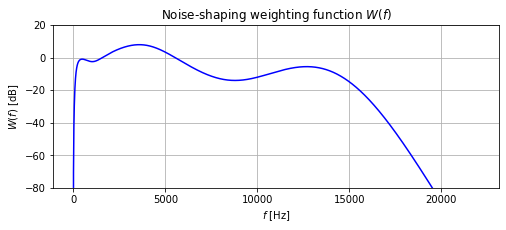

In [12]:
# To simplify the evaluation, we define unique zeros and their multiplicities.
zeros_unique = np.array([0, 0.58+1.03j, 0.58-1.03j, 3.18+8.75j, 3.18-8.75], 
                        dtype=np.complex128) * 2000 * np.pi
zero_multiplicity = [3, 1, 1, 3, 3]
# And same for the poles.
poles_unique = np.array([0.18, 1.63, 2.51+3.85j, 2.51-3.85j, 6.62+14.29j, 6.62-14.29j], 
                        dtype=np.complex128) * 2000 * np.pi
pole_multiplicity = [3, 2, 4, 4, 20, 20]

# Compute all the zeros and poles from the description above.
zeros = np.array([], dtype=np.complex128)
poles = np.array([], dtype=np.complex128)
for i, m in enumerate(zero_multiplicity):
    zeros = np.append(zeros, np.tile(zeros_unique[i], (m,)))
for i, m in enumerate(pole_multiplicity):
    poles = np.append(poles, np.tile(poles_unique[i], (m,)))

# Compute the transfer function from the zero-pole representation.
b, a = signal.zpk2tf(zeros, poles, 1.0)

# Compute the gain correction to have -2.515 dB at 1 kHz.
s_1khz = 2j * np.pi * 1000
gain_1khz = np.polyval(b, s_1khz) / np.polyval(a, s_1khz)
gain_corr = 10**(-2.515/20) / gain_1khz

# Evaluate the transfer function at all frequencies up to Nyquist.
n_freqs = 2048
freqs = np.linspace(0, fs/2, n_freqs)
tf = np.zeros(freqs.shape, dtype=np.complex128)
for i, f in enumerate(freqs):
    s = 2j * np.pi * f
    tf[i] = gain_corr * np.polyval(b, s) / np.polyval(a, s)
    
plt.figure(figsize=(8, 3))

plt.plot(freqs, 20*np.log10(np.abs(tf)+1e-12), color='blue')
plt.ylim([-80, 20])
plt.xlabel('$f$ [Hz]')
plt.ylabel('$W(f)$ [dB]')
plt.title("Noise-shaping weighting function $W(f)$")
plt.grid()

plt.show()

## A different perspective on the Tsividis paradox

Let me try to explain the paradox to begin with: listening to a CD with Ravel's Bolero (known for its use of a long crescendo), Tsividis noticed atrocious distortions when a flute plays - quietly of course - at the very beginning of the piece. Given those, he posed a question on the kind of interplay between analog, digital, and the quantization process itself that could explain the unrecognizable all-but-pleasant sound of the flute.

My explanation is very simple, which doesn't mean it's correct (Occam's razor can be only a razor, after all). I claim the annoying distortion could be attributed to the inadequacy of (re)quantization, probably due to the lack of appropriate dithering and/or noise shaping used for mastering the CD. This notebook was also an attempt to explain my hypothesis.


#### Code example: Bolero's dynamic range

Here we show the evolution of the signal power over the whole piece and try to get a feel of its dynamic range. We're not interested in the absolute values, of course, but of the decibel range going from the quietest to the loudest part.

It will turn out that the observed range, at least when the power is averaged over half-second intervals, is around 60 decibels. Of course, to capture variations on a shorter scale without distortions on either end (quiet and loud), one expects some safety margin to be added on both.

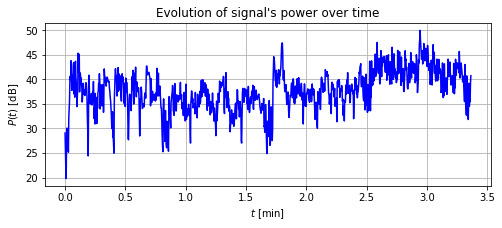

In [13]:
audio_file = 'audio/Bolero.wav'

fs, data = wavfile.read(audio_file)
if issubclass(data.dtype.type, np.integer):
    data = 1.0 * data / abs(np.iinfo(data.dtype).min)

# STFT parameters.
fft_size = 2**int(round(np.log2(fs/2))) # roughly 0.5 seconds
block_overlap = 0.5
win_type = 'hanning'

hop_size = int(round(fft_size * (1 - block_overlap)))

# Prepare the windowing function.
win = stft_window(fft_size, fft_size, win_type=win_type)

# Take only the left channel.
x = data[:, 0]

# Compute the power over time through the STFT.
t_stft, f_stft, x_stft = stft(x, win, hop_size)
x_psd = np.abs(x_stft)**2
x_pow = np.sum(np.abs(x_psd), axis=0)

plt.figure(figsize=(8, 3))

plt.plot(t_stft / fs / 60, 10 * np.log10(x_pow), color='blue')
plt.grid(True, which='both')
plt.xlabel('$t$ [min]')
plt.ylabel('$P(t)$ [dB]')
plt.title('Evolution of signal\'s power over time')

plt.show()

#### Code example: requantizing the part with the flute at the intro

Requantizing the recording, which already comes in 16-bit PCM and appears to be properly mastered (with dither and noise shaping) doesn't make too much sense. We can however contrive an inadequate mastering by reducing the resolution, say to 10 bits (something to play with) and listen to the differences between the vanilla quantization (neither dither nor noise shaping, to make the point of how bad things could be) and quantization done with dither and noise shaping.

In [14]:
# Boundaries of the excerpt we work with (in seconds).
t_start = 10
t_end = 27

# Parameters of the quantizer.
nbits = 10
nsteps = 2**nbits
midrise = True

# We assume that the signal amplitude is in interval [-1, 1]
step_size = 2 / nsteps

# Noise shaping filter.
a_h = np.array([1])
# Choose one of the filters listed in the cited paper.
# b_h = np.array([1])
# b_h = np.array([1.623, -0.982, 0.109])
b_h = np.array([2.412, -3.37, 3.937, -4.174, 3.353, -2.205, 1.281, -0.569, 0.0847]) 

x = data[int(t_start*fs):int(t_end*fs), 0]
t = np.arange(0, len(x)) / fs

nbits_is_6 = ipw.IntSlider(
    min=1, max=24, step=1, value=10, 
    description='$n_{\it bits}$', continuous_update=False)

midrise_cb_6 = ipw.Checkbox(description='midrise quantizer', value=True)

demo_out_6 = ipw.Output()

def update_quantize_bolero(nbits=10, midrise=True):
    nsteps = 2**nbits
    # We assume that the signal amplitude is in interval [-1, 1]
    step_size = 2 / nsteps
    
    # Quantize without dithering.
    y = quantize(x, step_size, midrise)

    # Generate dither.
    d_tpdf = dither_tpdf(step_size, len(x))

    # Quantize with dithering and noise shaping.
    y_ns = np.zeros(x.shape)
    if x.ndim > 1:
        for i in range(0, x.ndim):
            y_ns[:, i] = quantize_ns(x[:, i], d_tpdf, b_h, a_h, step_size, midrise)
    else:
        y_ns = quantize_ns(x, d_tpdf, b_h, a_h, step_size, midrise)
        
    audio_out_0 = ipw.Output()
    audio_out_1 = ipw.Output()
    audio_out_2 = ipw.Output()

    # Play the audio excerpts -- original and requantized.
    with audio_out_0:
        print('Original audio')
        display(ipd.Audio(data=np.clip(x, -1, 1), rate=fs, normalize=False))
    with audio_out_1:
        print('Quantized audio')
        display(ipd.Audio(data=np.clip(y, -1, 1), rate=fs, normalize=False))
    with audio_out_2:
        print('Quantized and noise-shaped audio')
        display(ipd.Audio(data=np.clip(y_ns, -1, 1), rate=fs, normalize=False))
    
    audio_group = ipw.HBox([audio_out_0, audio_out_1, audio_out_2])
    audio_group.layout = default_layout

    demo_out_6.clear_output()
    
    figure_out = ipw.Output()
    figure_out.layout = default_layout

    with figure_out:
        plt.figure(figsize=(15, 4))

        plt.subplot(1, 3, 1)
        plt.plot(t, x, color='blue')
        plt.xlabel('$t$ [s]')
        plt.ylabel('$s(t)$')
        plt.title('Original excerpt from Bolero', 
                  fontsize=12)
        plt.grid()

        plt.subplot(1, 3, 2)
        plt.plot(t, y, color='blue')
        plt.xlabel('$t$ [s]')
        plt.ylabel('$s(t)$')
        plt.title('Requantized w/o dither and noise shaping', 
                  fontsize=12)
        plt.grid()

        plt.subplot(1, 3, 3)
        plt.plot(t, y_ns, color='blue')
        plt.xlabel('$t$ [s]')
        plt.ylabel('$s(t)$')
        plt.title('Requantized w/ dithered noise shaping', 
                  fontsize=12)
        plt.grid()

        plt.tight_layout()
        plt.show()
        
    with demo_out_6:
        display(audio_group)
        display(figure_out)

def click_quantize_bolero(change):
    update_quantize_bolero(nbits=nbits_is_6.value, midrise=midrise_cb_6.value)

controls_6 = ipw.HBox([nbits_is_6, midrise_cb_6])
controls_6.layout = default_layout
run_button_6 = ipw.Button(description='Run')
run_button_6.on_click(click_quantize_bolero)

display(ipw.VBox([controls_6, run_button_6, demo_out_6]))
click_quantize_bolero(None)